# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux_NoVis/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
from ReplayBuffer import ReplayBuffer
import torch
import numpy as np
import os
from agent import DDPGAgent
from collections import namedtuple, deque
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
SOLVED_SCORE = 0.5
CONSECUTIVE_EPISODES = 100
PRINT_EVERY = 50
ADD_NOISE = True

In [9]:
# MADDPG function

def maddpg(agent_0, agent_1, n_episodes=2000, max_t=1000, train_mode=True):
    """Multi-Agent Deep Deterministic Policy Gradient (MADDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode

    """
    scores_window = deque(maxlen=CONSECUTIVE_EPISODES)
    scores_all = []
    scores_mean = []
    best_score = -np.inf
    best_episode = 0
    already_solved = False    

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]         # reset the environment
        states = np.reshape(env_info.vector_observations, (1,48)) # get states and combine them
        agent_0.reset()
        agent_1.reset()
        scores = np.zeros(num_agents)
        while True:
            action_0 = agent_0.act(states, ADD_NOISE)                          # agent 0 chooses an action
            action_1 = agent_1.act(states, ADD_NOISE)                          # agent 1 chooses an action
            actions = np.concatenate((action_0, action_1), axis=0).flatten()   # concatenate actions from agents 0 and 1

            env_info = env.step(actions)[brain_name]                           # send both agents' actions together to the environment
            next_states = np.reshape(env_info.vector_observations, (1, 48))    # combine the agent next states
            rewards = env_info.rewards                                         # get rewards
            done = env_info.local_done                                         # check if episode finished
            agent_0.step(states, actions, rewards[0], next_states, done, 0)    # agent 1 learns
            agent_1.step(states, actions, rewards[1], next_states, done, 1)    # agent 2 learns
            scores += np.max(rewards)                                          # update the score for each agent
            states = next_states                                               # roll over states to next time step
            if np.any(done):                                                   # exit loop if episode finished
                break

        ep_best_score = np.max(scores)                   # get higher score on the episode
        scores_window.append(ep_best_score)              # add to scores window
        scores_all.append(ep_best_score)                 # and to all scores
        scores_mean.append(np.mean(scores_window))       # compute the mean

        # save best score                        
        if ep_best_score > best_score:
            best_score = ep_best_score
            best_episode = i_episode
        
        # print results
        if i_episode % PRINT_EVERY == 0:
            print('Episodes {:0>4d}-{:0>4d}\tMax Reward: {:.3f}\tMean (window): {:.3f}'.format(
                i_episode-PRINT_EVERY, i_episode, np.max(scores_all[-PRINT_EVERY:]), scores_mean[-1]))

        # determine if environment is solved and keep best performing models
        if scores_mean[-1] >= SOLVED_SCORE:
            print('<-- Environment solved in {:d} episodes! \
            \n<-- Mean (window): {:.3f} over past {:d} episodes'.format(
                i_episode-CONSECUTIVE_EPISODES, scores_mean[-1], CONSECUTIVE_EPISODES))
            # save weights
            torch.save(agent_0.actor.state_dict(), 'models/checkpoint_actor_0.pth')
            torch.save(agent_0.critic.state_dict(), 'models/checkpoint_critic_0.pth')
            torch.save(agent_1.actor.state_dict(), 'models/checkpoint_actor_1.pth')
            torch.save(agent_1.critic.state_dict(), 'models/checkpoint_critic_1.pth')
            break
            
    return scores_all, scores_mean

In [10]:
# initialize agents
agent_0 = DDPGAgent(state_size, action_size, num_agents=1, random_seed=0)
agent_1 = DDPGAgent(state_size, action_size, num_agents=1, random_seed=0)

In [11]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
LEARN_EVERY = 1         # learning timestep interval
LEARN_NUM = 5           # number of learning passes
GAMMA = 0.99            # discount factor
TAU = 7e-2              # for soft update of target parameters
OU_SIGMA = 0.2          # Ornstein-Uhlenbeck noise parameter, volatility
OU_THETA = 0.12         # Ornstein-Uhlenbeck noise parameter, speed of mean reversion
EPS_START = 5           # initial value for epsilon in noise decay process in Agent.act()
EPS_EP_END = 250        # episode to end the noise decay process
EPS_FINAL = 0           # final value for epsilon after decay

In [12]:
scores, avgs = maddpg(agent_0, agent_1, n_episodes=2000, max_t=1000, train_mode=True)

Episodes 0000-0050	Max Reward: 0.200	Mean (window): 0.016
Episodes 0050-0100	Max Reward: 0.200	Mean (window): 0.025
Episodes 0100-0150	Max Reward: 0.200	Mean (window): 0.056
Episodes 0150-0200	Max Reward: 0.600	Mean (window): 0.074
Episodes 0200-0250	Max Reward: 0.600	Mean (window): 0.080
Episodes 0250-0300	Max Reward: 0.500	Mean (window): 0.104
Episodes 0300-0350	Max Reward: 0.300	Mean (window): 0.117
Episodes 0350-0400	Max Reward: 0.600	Mean (window): 0.140
Episodes 0400-0450	Max Reward: 0.600	Mean (window): 0.156
Episodes 0450-0500	Max Reward: 0.600	Mean (window): 0.145
Episodes 0500-0550	Max Reward: 1.300	Mean (window): 0.205
Episodes 0550-0600	Max Reward: 1.100	Mean (window): 0.290
Episodes 0600-0650	Max Reward: 1.200	Mean (window): 0.293
Episodes 0650-0700	Max Reward: 2.200	Mean (window): 0.363
<-- Environment solved in 636 episodes!             
<-- Mean (window): 0.506 over past 100 episodes


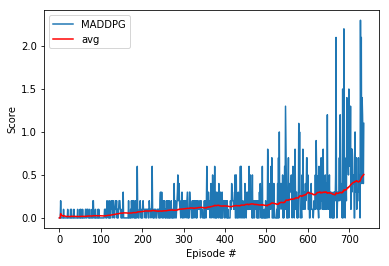

In [13]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='MADDPG')
plt.plot(np.arange(len(scores)), avgs, c='r', label='avg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()
